In [28]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

%precision 4

prng = np.random.RandomState(20250303)


# PCA on the wine dataset

## Know your data

The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the three types of wine.

UCI dataset: https://archive.ics.uci.edu/dataset/109/wine

In [29]:
X, y = load_wine(return_X_y=True, as_frame=True)
scaler = StandardScaler().set_output(transform="pandas")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=prng
)
scaled_X_train = scaler.fit_transform(X_train)

In [30]:
X_train.shape

(124, 13)

In [31]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
69,12.21,1.19,1.75,16.8,151.0,1.85,1.28,0.14,2.50,2.85,1.28,3.07,718.0
8,14.83,1.64,2.17,14.0,97.0,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0
101,12.60,1.34,1.90,18.5,88.0,1.45,1.36,0.29,1.35,2.45,1.04,2.77,562.0
74,11.96,1.09,2.30,21.0,101.0,3.38,2.14,0.13,1.65,3.21,0.99,3.13,886.0
48,14.10,2.02,2.40,18.8,103.0,2.75,2.92,0.32,2.38,6.20,1.07,2.75,1060.0


## PCA

In [32]:
pca = PCA().fit(X_train)

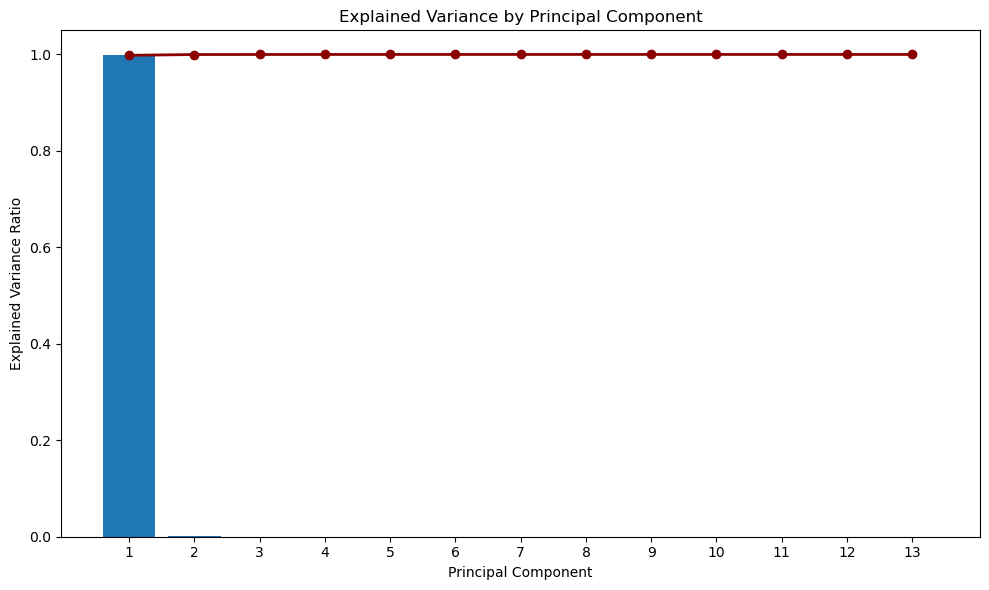

In [46]:

explained_variance = pca.explained_variance_ratio_

def visualizeExplainedVariance(explained_variance):
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance)
    plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), color="darkred", marker="o", linewidth=2)

    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Explained Variance by Principal Component")
    plt.xticks(range(1, len(explained_variance) + 1))
    plt.tight_layout()

visualizeExplainedVariance(pca.explained_variance_ratio_)

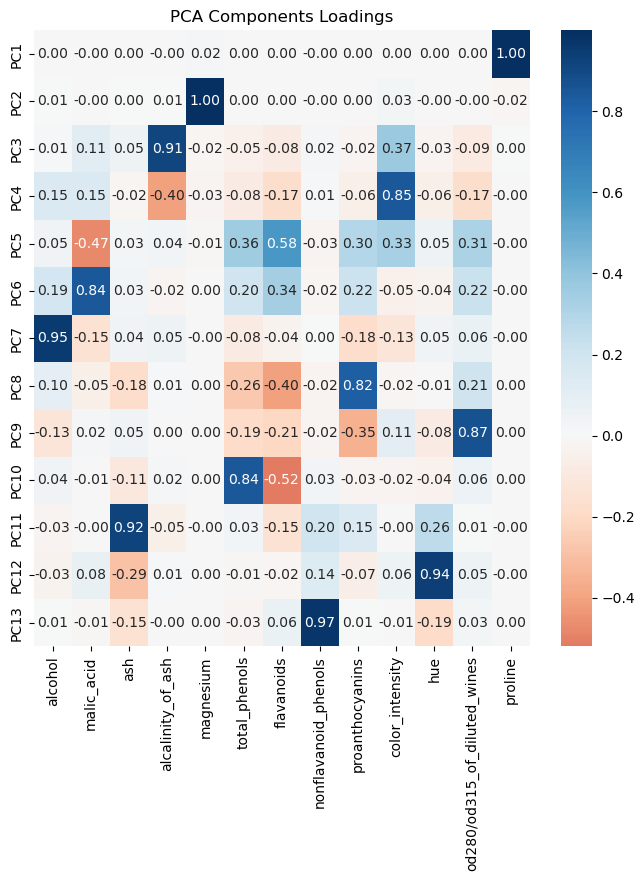

In [34]:
def visualizePCALoadings(pca, data):
    plt.figure(figsize=(8, 8))
    sns.heatmap(
        pca.components_, 
        cmap='RdBu', center=0, annot=True, fmt='.2f', 
        xticklabels=data.columns, 
        yticklabels=[f"PC{i+1}" for i in range(pca.n_components_)]
    )
    plt.title('PCA Components Loadings')

visualizePCALoadings(pca, X_train)

In [35]:
np.var(X_train, axis=0)

alcohol                              0.723307
malic_acid                           1.243164
ash                                  0.071704
alcalinity_of_ash                   11.013342
magnesium                          190.515609
total_phenols                        0.400793
flavanoids                           1.010651
nonflavanoid_phenols                 0.015934
proanthocyanins                      0.313177
color_intensity                      5.984922
hue                                  0.054193
od280/od315_of_diluted_wines         0.529550
proline                         100433.336368
dtype: float64

### Scaling

In [36]:
scaled_pca = PCA().fit(scaled_X_train)

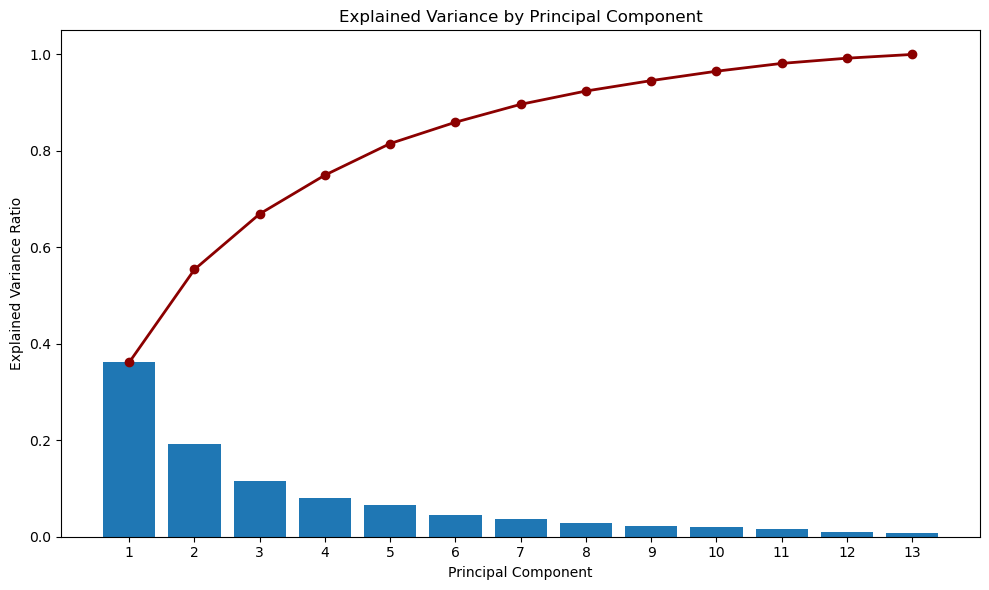

In [47]:
visualizeExplainedVariance(scaled_pca.explained_variance_ratio_)

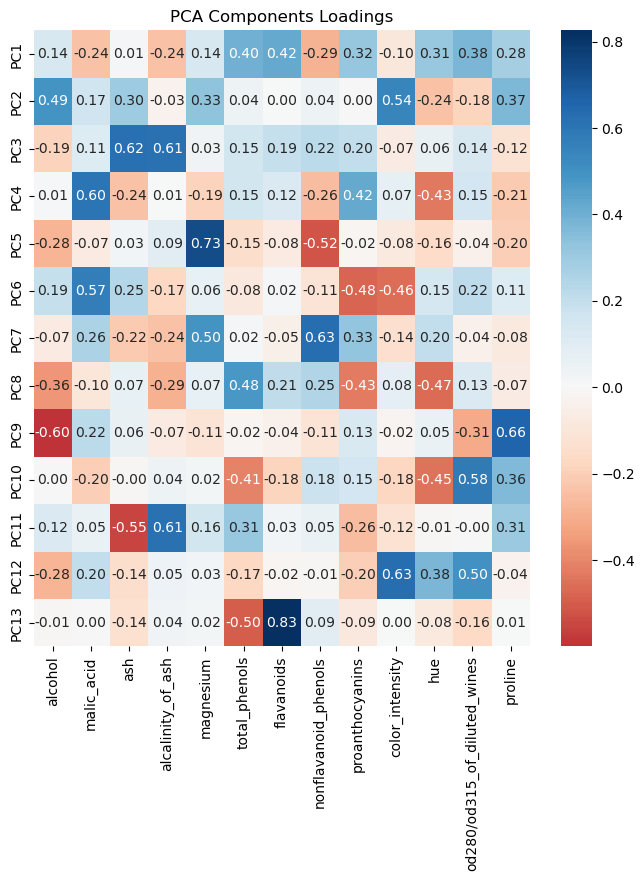

In [38]:
visualizePCALoadings(scaled_pca, X_train)

In [39]:
# Calculate reconstruction error (average Euclidean distance) for 90% PCA
def calculateReconstructionError(X, X_reconstructed):
    return np.mean(np.sum(np.square(X - X_reconstructed),axis=1))

n_components_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
scaled_n_components_90 = np.argmax(np.cumsum(scaled_pca.explained_variance_ratio_) >= 0.9) + 1

print(f"Number of components needed to explain 90% of variance: {n_components_90}")
print(f"Number of components needed to explain 90% of variance (scaled): {scaled_n_components_90}")

pca_90 = PCA(n_components=n_components_90).fit(X_train)
scaled_pca_90 = PCA(n_components=scaled_n_components_90).fit(scaled_X_train)

X_test_reconstructed = pca_90.inverse_transform(pca_90.transform(X_test))
reconstruction_error = calculateReconstructionError(X_test, X_test_reconstructed)

scaled_X_test = scaler.transform(X_test)
X_test_reconstructed_scaled = scaled_pca_90.inverse_transform(scaled_pca_90.transform(scaled_X_test))
reconstruction_error_scaled = calculateReconstructionError(scaled_X_test, X_test_reconstructed_scaled)

print(f"Reconstruction error: {reconstruction_error:.2f}")
print(f"Reconstruction error scaled: {reconstruction_error_scaled:.2f}")

Number of components needed to explain 90% of variance: 1
Number of components needed to explain 90% of variance (scaled): 8
Reconstruction error: 208.53
Reconstruction error scaled: 1.16


### Could we find the optimal number of components? Like you did with hyperparameter tuning in DA3?

Reconstruction error on both train and test sets will be monotonically decreasing as we increase the number of components. So we cannot use cross-validation alone to find the optimal number of components that minimizes the reconstruction error.

If we use all the features as components, PCA doesn't actually reduce dimensionality--it simply rotates your data using an orthogonal transformation. This rotation is invertible, so the reconstruction error will be zero both on train and test sets.

To choose the number of components, we can use the elbow method. We plot the reconstruction error as a function of the number of components, and look for the elbow point. However, it does not offer a clear-cut answer. It is rather a heuristic to balance between model complexity and performance. Additionally, your choice of the number of components should be guided by the problem you are trying to solve.



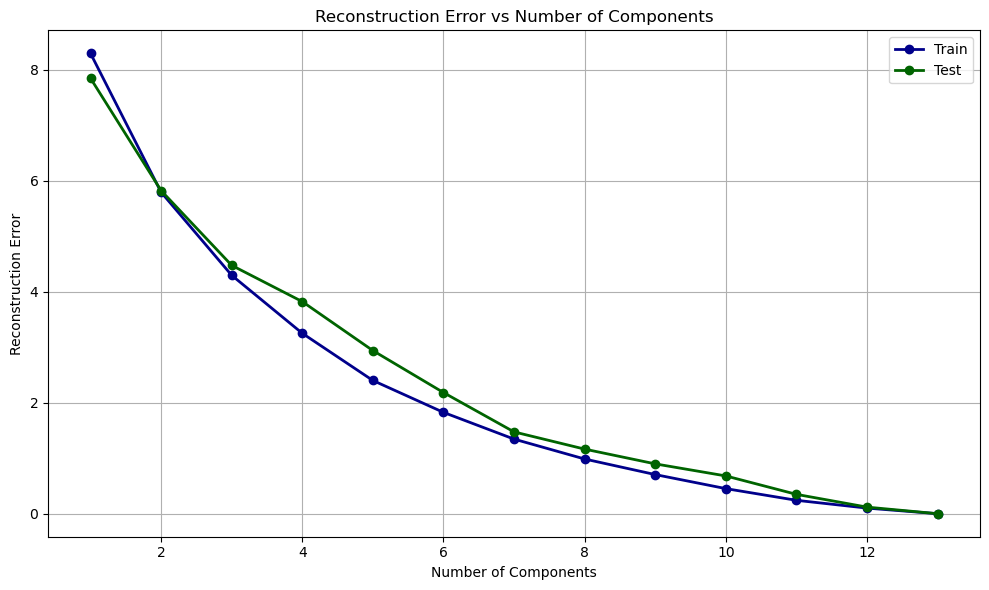

In [48]:
# Calculate reconstruction error for different numbers of components
n_components_range = range(1, 14)
train_errors = []
test_errors = []

for n in n_components_range:
    # Fit PCA with n components
    pca_n = PCA(n_components=n).fit(scaled_X_train)
    
    # Transform and reconstruct training data
    X_train_reconstructed = pca_n.inverse_transform(pca_n.transform(scaled_X_train))
    train_error = calculateReconstructionError(scaled_X_train, X_train_reconstructed)
    train_errors.append(train_error)
    
    # Transform and reconstruct test data 
    X_test_reconstructed = pca_n.inverse_transform(pca_n.transform(scaled_X_test))
    test_error = calculateReconstructionError(scaled_X_test, X_test_reconstructed)
    test_errors.append(test_error)

# Plot reconstruction errors
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, train_errors, color="darkblue", marker="o", linewidth=2, label="Train")
plt.plot(n_components_range, test_errors, color="darkgreen", marker="o", linewidth=2, label="Test")
plt.xlabel("Number of Components")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error vs Number of Components")
plt.grid(True)
plt.legend()
plt.tight_layout()


## Segmentation

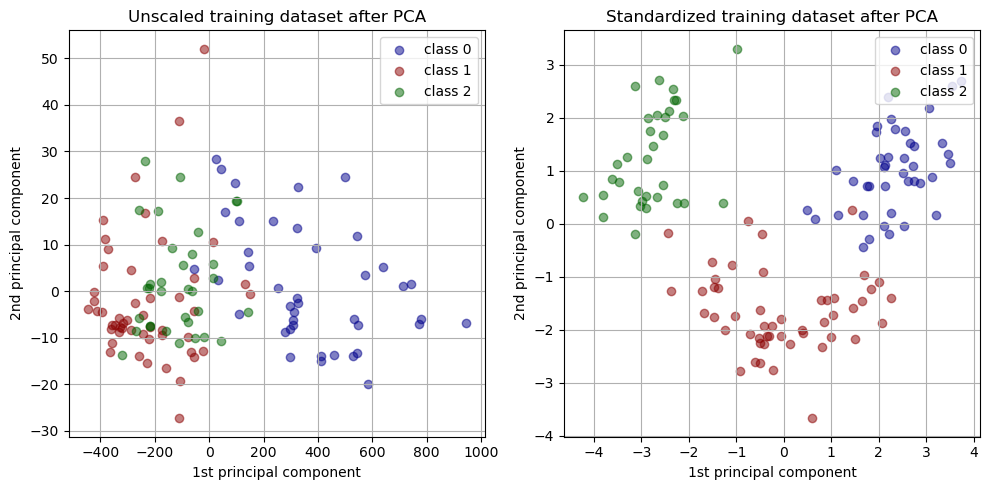

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

target_classes = range(0, 3)
colors = ("darkblue", "darkred", "darkgreen")

for target_class, color in zip(target_classes, colors):
    ax1.scatter(
        x=pca.transform(X_train)[y_train == target_class, 0],
        y=pca.transform(X_train)[y_train == target_class, 1],
        color=color,
        label=f"class {target_class}",
        alpha=0.5
    )

    ax2.scatter(
        x=scaled_pca.transform(scaled_X_train)[y_train == target_class, 0],
        y=scaled_pca.transform(scaled_X_train)[y_train == target_class, 1],
        color=color,
        label=f"class {target_class}",
        alpha=0.5
    )

ax1.set_title("Unscaled training dataset after PCA")
ax2.set_title("Standardized training dataset after PCA")

for ax in (ax1, ax2):
    ax.set_xlabel("1st principal component")
    ax.set_ylabel("2nd principal component")
    ax.legend(loc="upper right")
    ax.grid()

plt.tight_layout()

For this particular problem, it seems that the first two principal components are enough to separate the classes (once you correctly scale the data). The two components are certainly unable to preserve all the information, but they are enough to segment the wines into their classes.

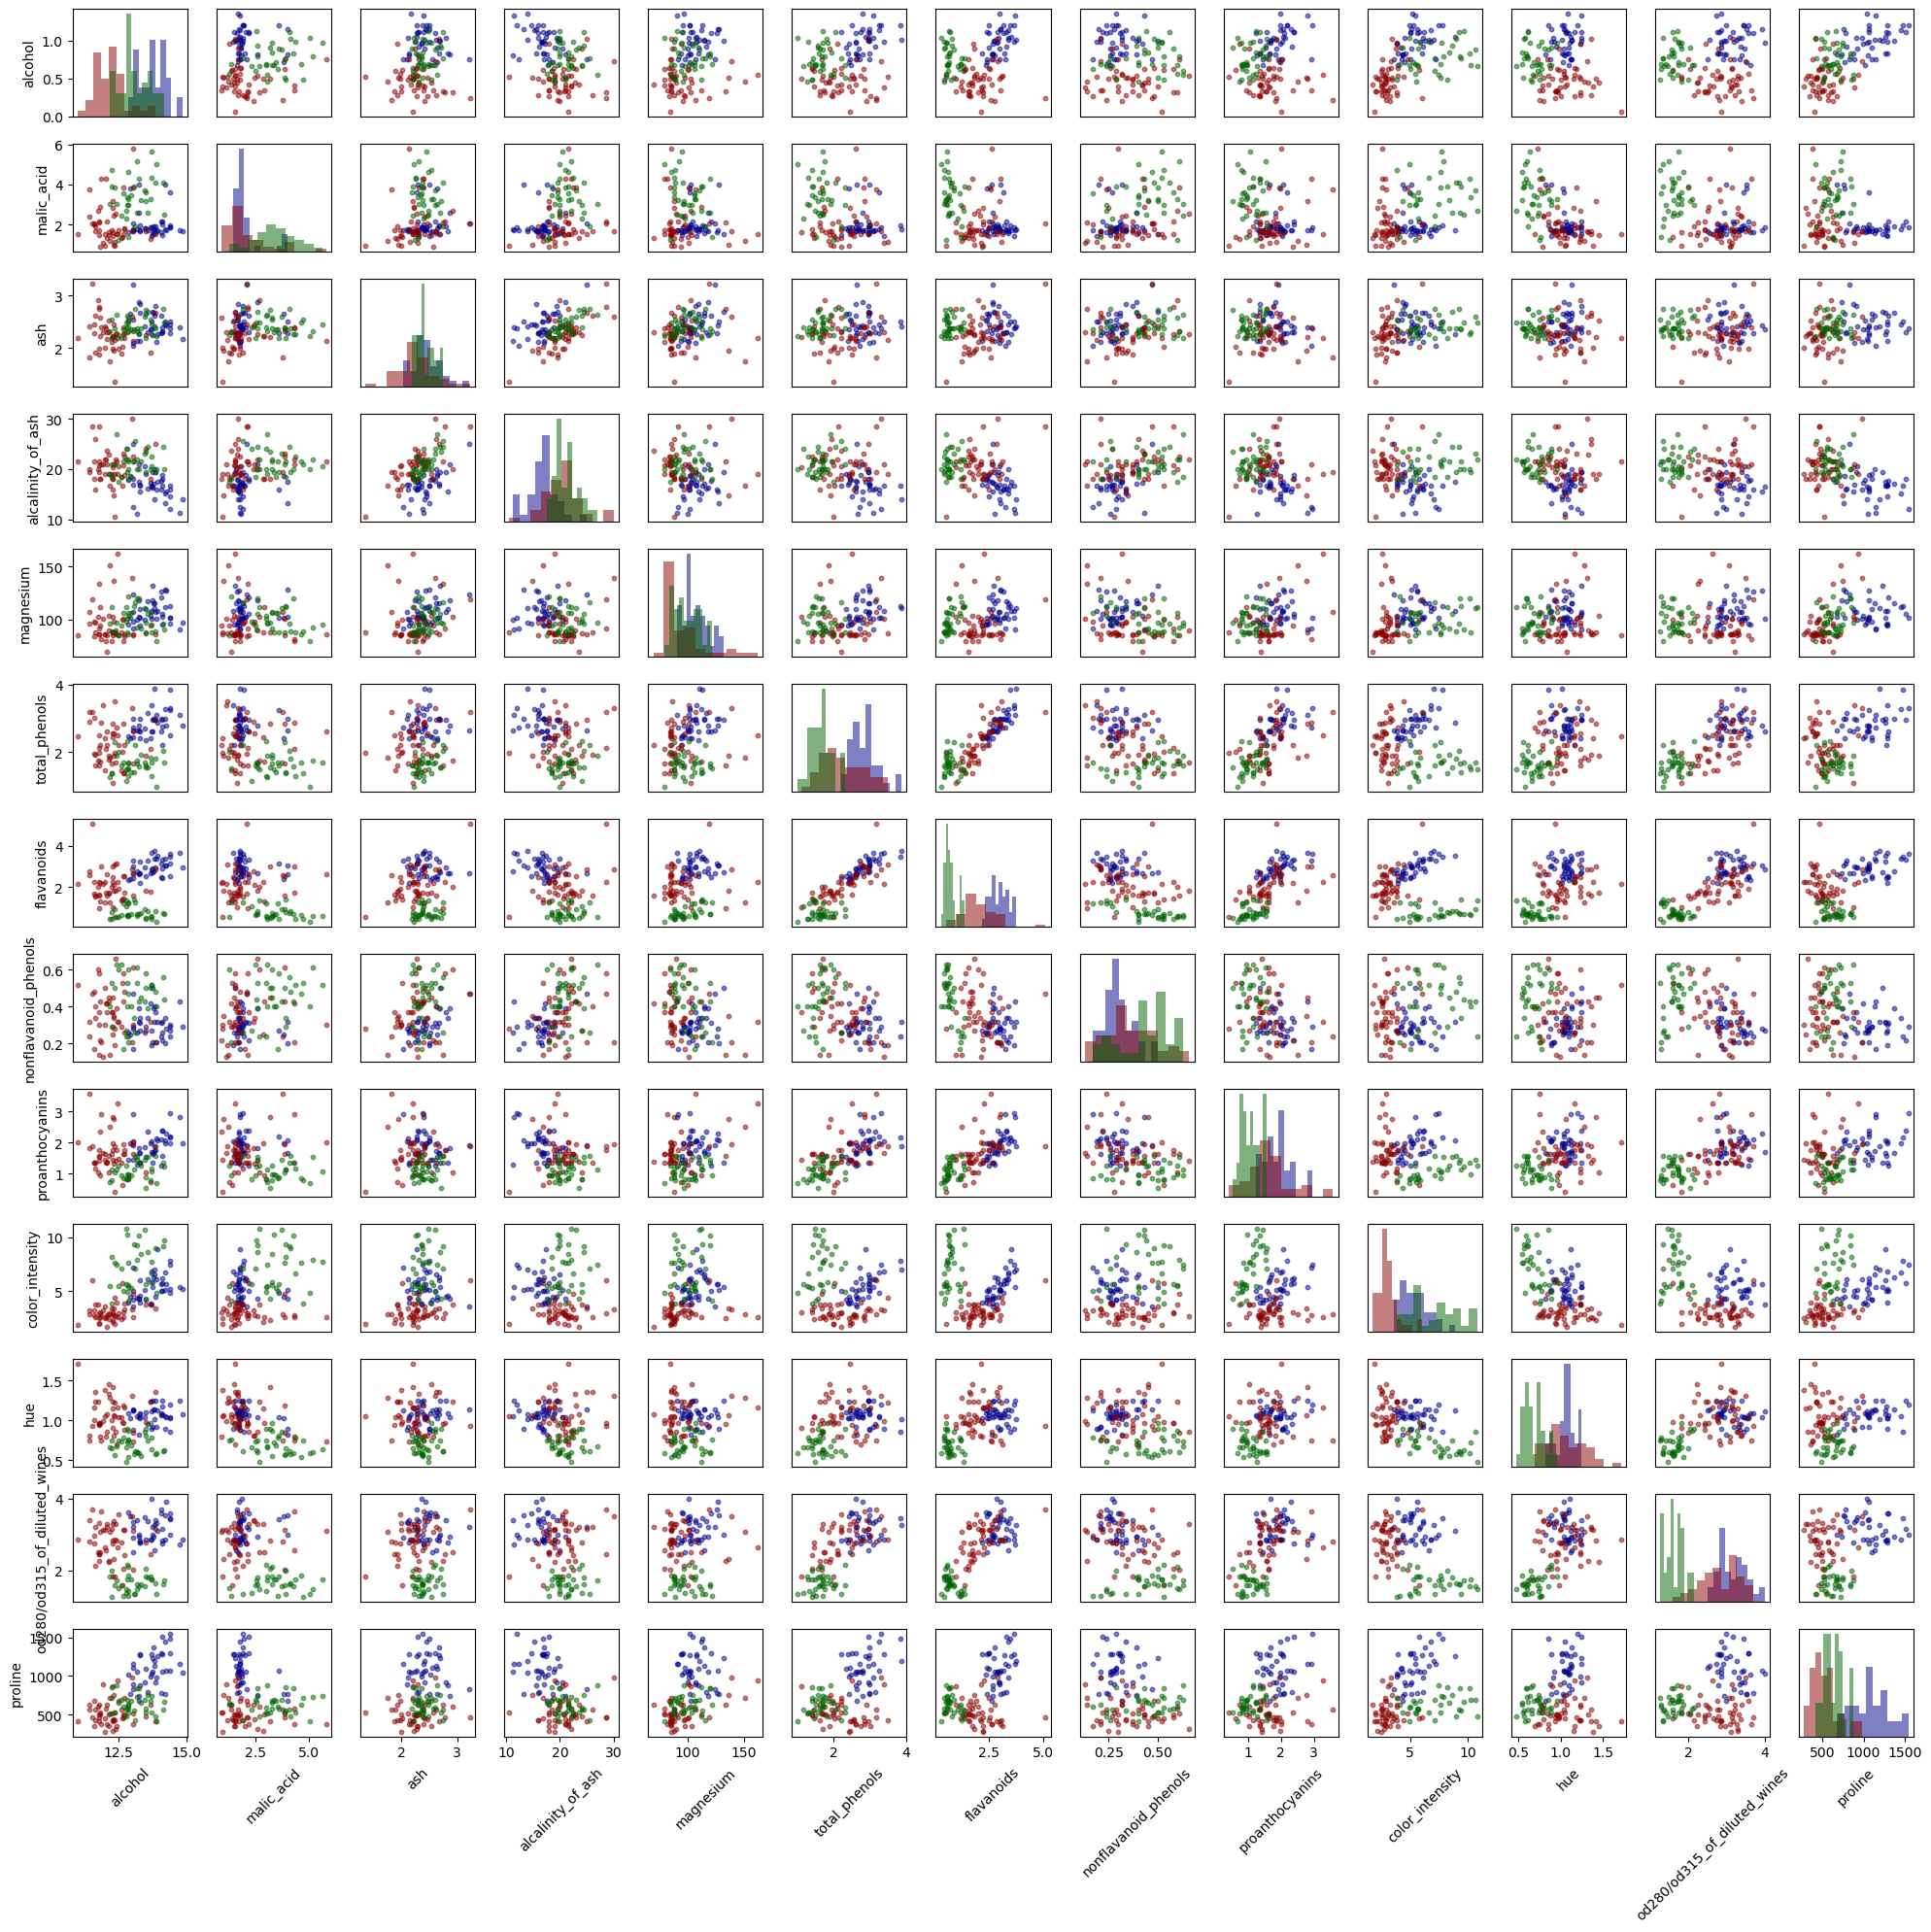

In [74]:
# Create a scatter plot matrix of all features colored by class
fig, axes = plt.subplots(nrows=13, ncols=13, figsize=(20, 20))
feature_names = X_train.columns

target_classes = range(0, 3)
colors = ("darkblue", "darkred", "darkgreen")

# Plot each feature against each other
for i in range(13):
    for j in range(13):
        ax = axes[i, j]
        
        # Plot diagonal histogram
        if i == j:
            for target_class, color in zip(target_classes, colors):
                ax.hist(X_train.iloc[(y_train == target_class).values, i], 
                       color=color, alpha=0.5, density=True)
        # Plot scatter for different features
        else:
            for target_class, color in zip(target_classes, colors):
                ax.scatter(X_train.iloc[(y_train == target_class).values, j],
                           X_train.iloc[(y_train == target_class).values, i],
                           c=color, alpha=0.5, s=10)
        
        # Only show x labels on bottom row
        if i == 12:
            ax.set_xlabel(feature_names[j], rotation=45)
        else:
            ax.set_xticks([])
            
        # Only show y labels on first column    
        if j == 0:
            ax.set_ylabel(feature_names[i])
        else:
            ax.set_yticks([])

plt.tight_layout()
